In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import config
from os.path import join
dataDir = config.DATADIR
from utils import loadData

In [2]:
df_A_R,df_A_S,df_A_V,df_H_R,df_H_S,df_date,df_S_id=loadData()

# Missing values

There is not missing data.

# Data  consistency and validity

In this section we check if the data values are consistent and valid.

## Validity of foreign keys

In this section we check if each `store_id` in the `reserve` table exists in the `store` table.

###  hpg

In [11]:
df=df_H_R.hpg_store_id.describe()
print('there are {} unique store ids in hpg-reserve table.'.format(df['unique']))
print('there are {} unique store ids in hpg-store table.'.format(df_H_S.hpg_store_id.unique().size))

there are 13325 unique store ids in hpg-reserve table.
there are 4690 unique store ids in hpg-store table.


So, there are many stores ids in the resesrve table which do not exist in the store table. The transactions related to these stores should be deleted from the reserve table because we cannot join them with the store table.

### air 

In [12]:
df=df_A_R.air_store_id.describe()
print('there are {} unique store ids in air-reserve table.'.format(df['unique']))
print('there are {} unique store ids in air-store table.'.format(df_A_S.air_store_id.unique().size))

there are 314 unique store ids in air-reserve table.
there are 829 unique store ids in air-store table.


In [13]:
df=pd.DataFrame({'air_store_id':df_A_R.air_store_id.unique()})
df[~df.air_store_id.isin(df_A_S.air_store_id)]

,air_store_id


So for the air dataset, all store ids in the reserve table exist in the store table.

## Reserve date should be less than Visit date

In [6]:
df_A_R[df_A_R['visit_datetime']<df_A_R['reserve_datetime']].shape

(0, 4)

In [7]:
df_H_R[df_H_R['visit_datetime']<df_H_R['reserve_datetime']].shape

(0, 4)

## Validity of latitude and longitude values

In [18]:
pd.DataFrame([df_A_S.longitude.describe(),df_A_S.latitude.describe(),
              df_H_S.longitude.describe(),df_H_S.latitude.describe()])

,count,mean,std,min,25%,50%,75%,max
longitude,829.0,137.415311,3.650971,130.195555,135.341564,139.685474,139.751599,144.273398
latitude,829.0,35.647042,2.084659,33.211967,34.695124,35.658068,35.694003,44.020632
longitude,4690.0,137.675816,3.197233,130.339313,135.498859,139.495733,139.737998,143.714585
latitude,4690.0,35.810261,2.138755,33.311645,34.692109,35.659214,35.703381,43.774846


Minimum and maximum values for both tables are in reasonable ranges.

## Joining the two datasets

There are only 150 stores which have data in both air and hpg datasets. The number of stores in each dataset is:

In [58]:
air_unique_stores = df_A_S.air_store_id.unique().size
hpg_unique_stores = df_H_S.hpg_store_id.unique().size
print((air_unique_stores,hpg_unique_stores))

(829, 4690)


## Consistancy of lat and lon values in hpg and air

Here we check if the lat and lon values for those stores in both dataset are consistent.

Text(0.5,0,u'difference in lon')

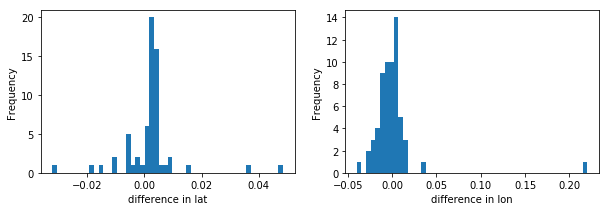

In [33]:
df=df_S_id.merge(df_A_S,on=['air_store_id']).merge(df_H_S,on='hpg_store_id')
fig=plt.figure(figsize=(10,3))
fig.add_subplot(121)
_=(df.latitude_x-df.latitude_y).plot.hist(bins=50)
plt.xlabel('difference in lat')
fig.add_subplot(122)
_=(df.longitude_x-df.longitude_y).plot.hist(bins=50)
plt.xlabel('difference in lon')

There is one store whose difference in longitude is larger than 0.2. We identify it:

In [34]:
df[(df.longitude_x-df.longitude_y)>.2]

,air_store_id,hpg_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
39,air_640cf4835f0d9ba3,hpg_e63863c8987bd064,Izakaya,Tōkyō-to Ōta-ku Kamata,35.561257,139.716051,Japanese style,Kanagawa-ken Yokohama-shi Nagatsutachō,35.512762,139.495733


However this is not the case for `area_name` and `genre_name`:

In [36]:
df[df.air_area_name!=df.hpg_area_name].shape

(58, 10)

In [59]:
df[df.air_genre_name!=df.hpg_genre_name].shape

(62, 10)

In [40]:
df_A_S.air_store_id.unique().size

829

So it does not seem that joining the two datasets will be much helpful.

# Distance between stores in air and hpg datasets 

In this section we compute and visualize the distance between each store in the air dataset and the stores in the hpg dataset. The goal here is to see if for each store in the air dataset we can find a store in the hpg using the distance. 

In [38]:
n_hpg=df_H_S.shape[0];n_air=df_A_S.shape[0];
lat_hpg=df_H_S.latitude.values.reshape((n_hpg,1));lon_hpg=df_H_S.longitude.values.reshape((n_hpg,1))
lat_air=df_A_S.latitude.values.reshape((n_air,1));lon_air=df_A_S.longitude.values.reshape((n_air,1))

lat_dist = np.tile(lat_air**2,(1,n_hpg))+\
           np.tile(lat_hpg.transpose()**2,(n_air,1))-\
           2*np.dot(lat_air,lat_hpg.transpose())
lon_dist = np.tile(lon_air**2,(1,n_hpg))+\
           np.tile(lon_hpg.transpose()**2,(n_air,1))-\
           2*np.dot(lon_air,lon_hpg.transpose())
dist = np.sqrt(lat_dist+lon_dist)        

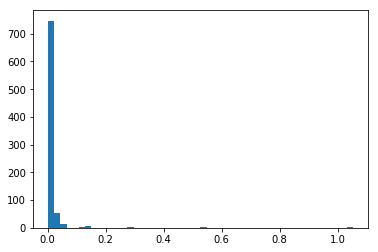

In [40]:
_=plt.hist(dist.min(axis=1),bins=50)

In [37]:
dist.shape

(829, 4690)

# Conclusion

+ delete those transactions in the `hpg-reserve` table whose store id does not exist in the store table.